# Nitrogen vacancy centers: narrow-band spectroscopy

**Using BOULDER OPAL spectrum reconstruction tools to perform provably optimal leakage-free sensing with spectrally concentrated Slepian pulses**

BOULDER OPAL enables you to create, apply, and analyze customized sensing procedures in quantum magnetometers. In this Application Note, we focus on a flexible protocol allowing you to use special controls which suppress spectral leakage. We explore the case of an NV center in diamond and perform a comparison of the flexible spectrum reconstruction techniques developed by the team at Q-CTRL with existing routines from the open literature. The Q-CTRL techniques provide the following major advantages:
1. Greater flexibility in how the spectrum is sampled,
1. Optimal minimization of out-of-band sensitivity to background noise,
1. Improved accuracy in reconstruction and higher computational efficiency.

The NV center is a spin-1 defect in diamond of significant experimental interest to room temperature quantum magnetometry and nano nuclear magnetic resonance (nano-NMR) spectroscopy, as well as sensing of electric fields, temperature and pressure in exotic environments. In practice, spectroscopy with NV centers typically relies on dynamic-decoupling-pulse sequence-based power spectrum reconstruction methods, such as the [Suter Alvarez](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.230501) (SA) method. Unfortunately, these pulse-based techniques can suffer out-of-band spectral leakage that can lead to signal misidentification. In these notes, you'll have the opportunity to use the BOULDER OPAL spectrum reconstruction toolkit together with narrowband Slepian-shaped pulses to achieve an accurate power spectrum reconstruction with the smallest achievable leakage signals allowed by mathematics. A detailed comparison of Slepian vs SA reconstruction appears in [Frey et al](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.14.024021).

The notebook is organized in two sections. In the first section, you'll explore the detrimental impacts of out-of-band leakage on the SA technique. In the second section, you'll use BOULDER OPAL to tackle the power spectrum reconstruction problem in a more sophisticated manner. Here you'll begin by driving the NV center using Slepian-based controls designed to provide harmonic-free sensing, rather than pulsed dynamic decoupling sequences. You'll then account for the precise spectral response of the controls by generating a high-resolution mapping between a power spectrum and results of lab measurements. Finally, by inverting this mapping, you'll be able to achieve accurate magnetic field spectrum reconstruction with minimal influence from background clutter.

*This notebook contains preview features that are not currently available in BOULDER OPAL. Please [contact us](https://q-ctrl.com/contact) if you want a live demonstration for your hardware. Preview features are included through the package `qctrlcore`, which is not publicly available: cells with `qctrlcore` will not be executable.*

## Imports and initialization

In [1]:
import copy
import time

import jsonpickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import qctrlcore as qc
import tensorflow as tf
from qctrlcore.filter_function import calculate_filter_function

# Plotting imports
from qctrlvisualizer import plot_controls


# Helper functions
def save_var(file_name, var):
    # Save a single variable to a file using jsonpickle
    f = open(file_name, "w+")
    to_write = jsonpickle.encode(var)
    f.write(to_write)
    f.close()


def load_var(file_name):
    # Return a variable from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded


def first_order_slepian_based_controls(
    maximum_rabi_rate, duration, number_of_segments, frequency
):
    """
    This function provides spectrally concentrated controls derived from first-order Slepian functions.
    """
    times = np.arange(0, number_of_segments + 1, 1) * duration / (number_of_segments)
    slepian_envelope = np.kaiser(number_of_segments + 1, 2 * np.pi)
    total_power = np.sum(np.abs(slepian_envelope * number_of_segments) ** 2)

    # COS shift
    cos_modulation = np.cos(2 * np.pi * frequency * times)
    slepian = cos_modulation * slepian_envelope

    # Compute the time derivative to obtain dephasing sensitivity
    slepian = slepian[:-1] - slepian[1:]

    # Rescale to maintain power
    slepian = slepian * np.sqrt(
        total_power / np.sum(np.abs(slepian * number_of_segments) ** 2)
    )

    # Set up the control format for core
    segment_duration = duration / (number_of_segments)
    phasors = maximum_rabi_rate * slepian + 0 * 1j
    controles_for_core = {
        "drives": [
            {
                "operator": qc.NonHermitianOperator(sigma_m / 2.0),
                "control": [qc.ComplexSegment(segment_duration, v) for v in phasors],
                "noise": False,
            }
        ]
    }

    return controles_for_core


colors = {"Q-CTRL_2": "#BF04DC", "Q-CTRL": "#680CE9", "Red": "#FF3860"}

sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

data_folder = "./resources/nitrogen-vacancy-centers-narrow-band-spectroscopy/"

## Model of the NV center and the magnetic spectrum
     
In this notebook, you'll use a single NV center to interrogate a given magnetic field spectrum over a specific window. To get you going, here's a brief look at the relevant NV center Hamiltonian.   

For the purposes of general magnetic field sensing, the ground state of the negatively charged NV center is well described by the following Hamiltonian:

\begin{align*}
H = DS_z^2 + \gamma_e B_0 S_z + \gamma_eB_1(\cos(\omega t +\phi)S_x + \sin(\omega t +\phi)S_y) + \gamma_e B_{AC} S_z,
\end{align*}

where $S_{x,y,z}$ are the $S=1$ spin operators and $\gamma_e$ is the gyromagnetic ratio of an electron. The $|\pm1\rangle$ levels are separated from $|0\rangle$ by the zero-field splitting $D=2.87{\rm GHz}$. The background magnetic field $B_0$ is applied along the direction of the NV center quantization axis. The driving field used to control the spin transitions has an amplitude $B_1$, frequency $\omega$, and relative phase $\phi$. Finally, $B_{AC}$ represents the component of the magnetic spectrum fluctuations in the direction of the NV center axis.

In sensing applications, it's typical to run pulse sequences on one of two spin transitions. Setting $\omega=D-\gamma_eB_0$ allows for resonant control of the $|0\rangle \leftrightarrow |-1\rangle$ transition without populating the $|+1\rangle$ level under usual experiment conditions ($D+\gamma_eB_0\gg \gamma_eB_1$). Therefore, this system can be effectively reduced to the following two level Hamiltonian:

\begin{align*}
H = D\frac{\sigma_z}{2} - \gamma_e B_0 \frac{\sigma_z}{2} + \gamma_eB_1\left(\cos(\omega t +\phi)\frac{\sigma_x}{2} + \sin(\omega t +\phi)\frac{\sigma_y}{2}\right) + \gamma_e B_{AC} \frac{\sigma_z}{2},
\end{align*}

where $\sigma_{x,y,z}$ are Pauli matrices. Finally, moving into the rotating frame, the Hamiltonian can be expressed as:

\begin{align*}
H = \Omega\frac{\sigma_x}{2} + \gamma_e B_{AC} \frac{\sigma_z}{2},
\end{align*}

where the driving filed has been absorbed into the complex Rabi rate $\Omega= \gamma_e B_1e^{i\phi}$.

The magnetic spectrum you'll be examining is shown below. It represents some complex environmental landscape containing multiple features, a trait found in various scenarios, from sensing macroscopic objects to nano-NMR. 

Your interest will be in interrogating a specific window of the spectrum from $\nu_{\rm min}$ to $\nu_{\rm max}$, here taken to be in the low MHz range. The particular range of the window (e.g., whether MHz, kHz, etc.) is arbitrary; however, as you'll see later, it's essential to note that the spectrum contains features outside of the interrogation window.

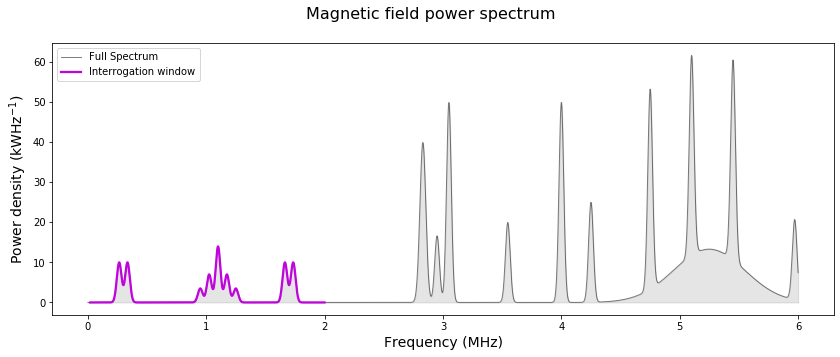

In [2]:
# Load power spectrum data
spectrum_data = load_var(data_folder + "spectrum_data")
spectrum_frequencies = spectrum_data["spectrum_frequencies"]
spectrum = spectrum_data["spectrum"]


# Interrogation window
lower_sample_frequency = 2e4
upper_sample_frequency = 2e6
sample_selection = (spectrum_frequencies >= lower_sample_frequency) & (
    spectrum_frequencies <= upper_sample_frequency
)
sample_frequencies = spectrum_frequencies[sample_selection]
sample_sepectrum = spectrum[sample_selection]

# Number of sampling points over the window
number_of_sample_points = 50


# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    spectrum_frequencies / 1e6,
    spectrum / 1e3,
    alpha=0.5,
    label="Full Spectrum",
    color="k",
    linewidth=1,
)
ax.fill_between(spectrum_frequencies / 1e6, spectrum / 1e3, 0, alpha=0.1, color="k")

ax.plot(
    sample_frequencies / 1e6,
    sample_sepectrum / 1e3,
    label="Interrogation window",
    color=colors["Q-CTRL_2"],
    linewidth=2.25,
)
# ax.fill_between(sample_frequencies/1e6, sample_sepectrum/1e3, 0, alpha=.5, color = colors["Q-CTRL_2"])

ax.set_xlabel("Frequency (MHz)", fontsize=14)
ax.set_ylabel("Power density (kWHz$^{-1}$)", fontsize=14)
ax.legend(loc="best")
fig.suptitle("Magnetic field power spectrum", fontsize=16)
plt.show()

Here is the spectrum example you'll be working with. The window you'll be interrogating is highlighted (pink), while the spectrum contains other features outside of it (gray).

## Spectrum reconstruction with Suter Alvarez

Conventional spectroscopy with NV centers often relies on pulse sequences of [Carr-Purcell-Meiboom-Gill (CPMG)](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_cpmg_sequence.html) or [XY](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_xy_concatenated_sequence.html) families, whose filter functions have nontrivial profiles. They are characterized by higher frequency harmonics which interfere with spectrum reconstruction. This issue leads to the appearance of spectrum-dependent artifacts and errors in peak magnitudes. 

In this section, we use the SA method to illustrates how out-of-band leakage causes issues with conventional approaches to spectrum reconstruction. The SA technique uses a series of CPMG sequences of fixed duration. It accounts for their harmonics by carefully choosing the sequence order to ensure overlaps between the fundamental and harmonic frequencies of successive sequences. This can be effective in partially mitigating the effects of harmonics in the filter functions, but cannot do so completely and simultaneously adds strict requirements on which measurement sequences may be used.


### Filter functions of sequences in conventional spectrum reconstruction approaches

Below you can see the filter functions of all the CPMG sequences used to probe your window of interest. Observe the multiple harmonics located outside the interrogation window. Note, you'll encounter a similar situation with pulse sequences of many other families.

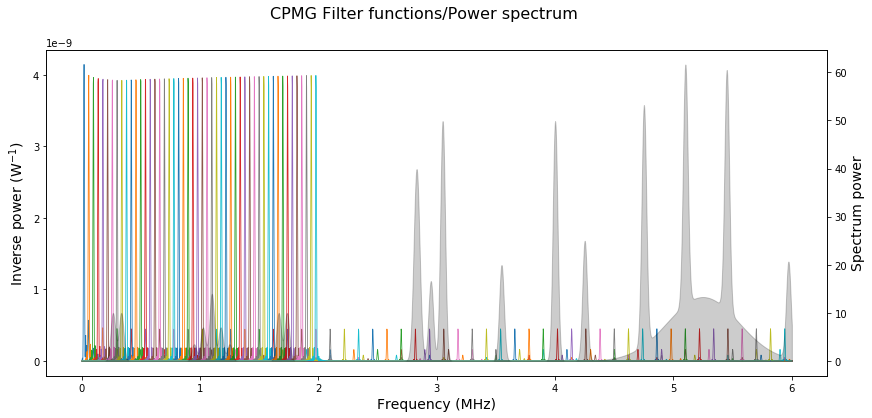

In [3]:
# Max Rabi rate of pulses
maximum_rabi_rate = 2.0 * np.pi * 20 * 1e6

# Duration of CPMG sequences
duration = 100e-6

# Shot noise
shot_noise = 1e-4

# Load Suter Alvarez reconstruction data
SA_data = load_var(data_folder + "SA_data")


SA_frequencies = SA_data["frequencies"]
SA_filter_functions = SA_data["filter_functions"]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
for ff in SA_filter_functions:
    ax.plot(SA_frequencies / 1e6, ff, linewidth=0.8)

ax.set_xlabel("Frequency (MHz)", fontsize=14)
ax.set_ylabel("Inverse power (W$^{-1}$)", fontsize=14)
fig.suptitle("CPMG Filter functions/Power spectrum", fontsize=16)

ax2 = ax.twinx()
ax2.fill_between(spectrum_frequencies / 1e6, spectrum / 1e3, 0, alpha=0.2, color="k")
ax2.set_ylabel("Spectrum power", fontsize=14)
plt.show()

Shown above are the filter functions of CPMG sequences spanning the interrogation window under the SA arrangement. Note that the higher order harmonics cover a significant portion of the spectrum outside the interrogation window. Those harmonics pick up the contributions from the unaccounted spectral components creating errors and artifacts in the reconstruction of the sampled spectrum.

### Measurements

The measurements for each of the CPMG sequences would be collected experimentally, however, here they have been simulated using the filter function framework. The probability of finding the NV center in the $m=-1$ state can be estimated as $P_i= \int F^i(\nu)S(\nu)d\nu + \epsilon_m $, where the $F^i(\nu)$ is the filter function of the $i^{th}$ CPMG sequence and $S(\nu)$ is the magnetic power spectrum density. For clarity, the shot noise $\epsilon_m$ is set to be negligible (standard deviation $\sigma=10^{-4}$).

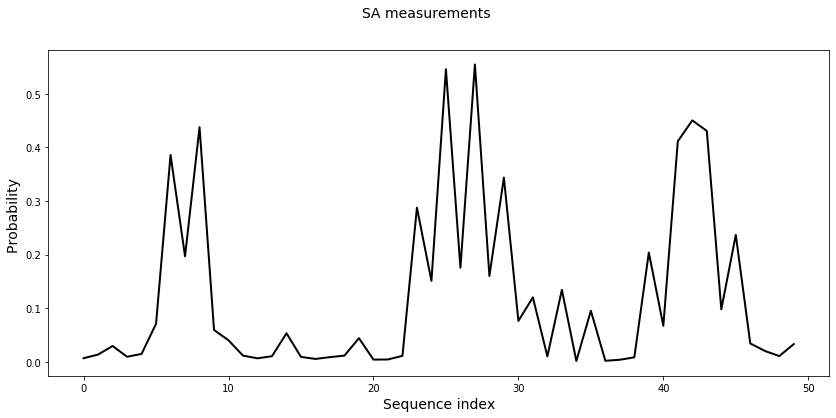

In [4]:
SA_measurements = [m["measurement"] for m in SA_data["measurement_list"]]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(
    SA_measurements,
    label="",
    linewidth=2,
    color="k",
)
ax.set_xlabel("Sequence index", fontsize=14)
ax.set_ylabel("Probability ", fontsize=14)
fig.suptitle("SA measurements", fontsize=14)
plt.show()

Probability of the $m=-1$ NV state for the index of the CPMG sequence.

### Sutter-Alvarez reconstruction

SA algorithm takes in the measurements associated with the CPMG sequences and produces the power spectrum shown below. Note, the spectrum reconstruction data presented in this section is provided by us for instructive purposes, we prepared it using the method developed by [G. A. Alvarez, D. Suter](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.230501).

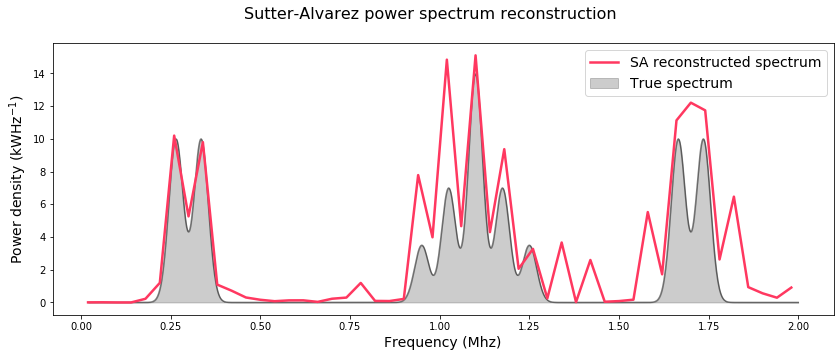

In [5]:
SA_reconstructed_frequencies = SA_data["reconstructed_frequencies"]
SA_reconstructed_power = SA_data["reconstructed_power"]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    sample_frequencies / 1e6,
    sample_sepectrum / 1e3,
    alpha=0.5,
    color="k",
    linewidth=1.5,
)
ax.fill_between(
    sample_frequencies / 1e6,
    sample_sepectrum / 1e3,
    0,
    alpha=0.20,
    color="k",
    label="True spectrum",
)
ax.plot(
    SA_reconstructed_frequencies / 1e6,
    SA_reconstructed_power / 1e3,
    "-",
    linewidth=2.5,
    color=colors["Red"],
    label="SA reconstructed spectrum",
)
ax.set_xlabel("Frequency (Mhz)", fontsize=14)
ax.set_ylabel("Power density (kWHz$^{-1}$)", fontsize=14)
ax.legend(loc="best", fontsize=14)

fig.suptitle("Sutter-Alvarez power spectrum reconstruction", fontsize=16)
plt.show()

The interrogated section of the spectrum highlights discrepancies between the true spectrum (gray) and the spectrum reconstructed with the Suter Alvarez technique (red). Observe that in comparison to the plot of measurements in the section above, the SA technique managed to correct the artifacts caused by harmonic within the interrogation window as seen around the feature on the left. However, SA misses some of the features of the real spectrum while simultaneously adding spurious ones due to the effects of out-of-band harmonic leakage, as seen in features in the middle and right. In this example, the amount of power that has leaked into the interrogation window is around $67\%$.

## Spectrum reconstruction with BOULDER OPAL

By following these steps, you'll build a spectrum reconstruction technique customized to your needs:
1. Pick the controls of your choice - in this case, you'll use Slepian-based controls in place of CPMG,
1. Collect your measurements $\mathbf{P}$, 
1. Construct the mapping $\mathbf{M}$ between measurements $\mathbf{P}$ and the power spectrum $\mathbf{S}$, where $\mathbf{P=MS}$,
1. Use $\mathbf{M}$ to reconstruct the power spectrum with high accuracy.

You can find more details about spectrum reconstruction in [this](https://docs.q-ctrl.com/boulder-opal/user-guides/noise-characterization-and-reconstruction) user guide.


### Slepian-based controls

Here you'll use first order Slepians to derive concentrated pulses that probe specific frequencies free of higher order harmonics. These pulses will have the same duration as the CPMG sequences above, however, they'll be composed of the time derivative of the continuous Slepian waveform modulated by the frequencies you want to interrogate. For details, see [Frey et al., Phys. Rev. Applied 2020](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.14.024021).

Below is the array of Slepian-based controls.

In [6]:
# Points at which to probe the frequency window
number_of_sample_points = 100
slepian_frequencies = np.linspace(
    lower_sample_frequency, upper_sample_frequency, number_of_sample_points
)

# Set up gradually varying Rabi rates to make filter function amplitudes constant
slepian_rabi_rate_0 = 2 * np.pi * 15e3
slepian_rabi_rates = slepian_rabi_rate_0 * slepian_frequencies / slepian_frequencies[0]

# Number of segments the Slepian pulse is discretized into
number_of_segments = 4000

# Generate the array of Slepian-based controls
slepian_based_controles = [
    first_order_slepian_based_controls(
        rabi_rate, duration, number_of_segments, frequency
    )
    for frequency, rabi_rate in zip(slepian_frequencies, slepian_rabi_rates)
]

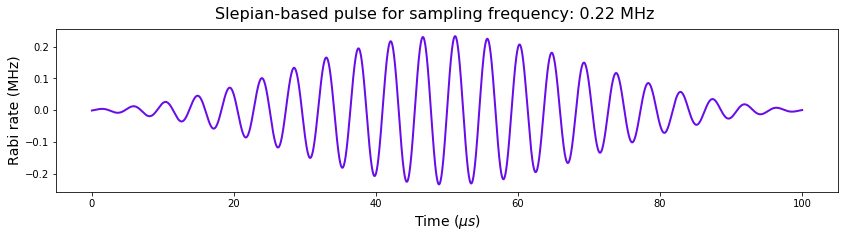

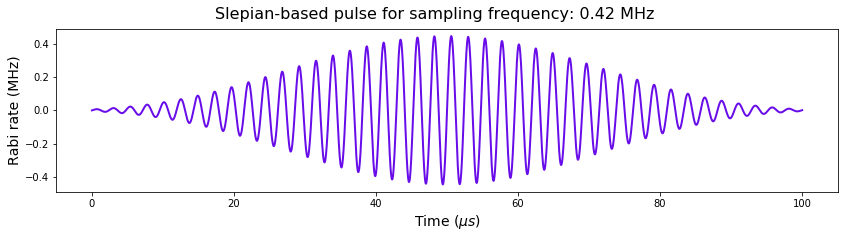

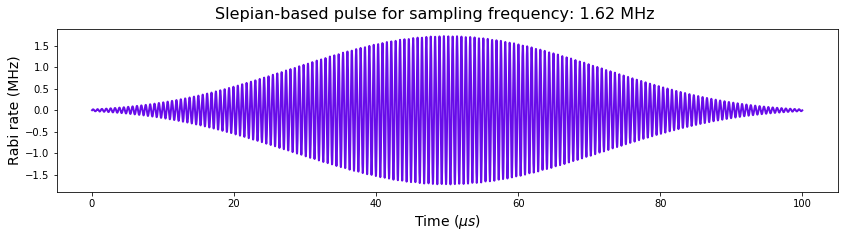

In [7]:
# Plot the Slepian-based controls
slepian_rabi_rates_for_plot = np.array(
    [
        [np.real(segment.value) for segment in core_controle["drives"][0]["control"]]
        for core_controle in slepian_based_controles
    ]
)

slepian_durations_for_plot = [
    [segment.duration for segment in core_controle["drives"][0]["control"]]
    for core_controle in slepian_based_controles
]

slepian_times_for_plot = [
    np.cumsum(durations) for durations in slepian_durations_for_plot
]

for idx in [10, 20, 80]:
    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(
        slepian_times_for_plot[idx] / 1e-6,
        slepian_rabi_rates_for_plot[idx] / np.pi / 2 / 1e6,
        alpha=1,
        color=colors["Q-CTRL"],
        linewidth=2,
    )

    ax.set_ylabel("Rabi rate (MHz)", fontsize=14)
    ax.set_xlabel("Time ($\mu s$)", fontsize=14)
    fig.suptitle(
        "Slepian-based pulse for sampling frequency: "
        + str(np.round(slepian_frequencies[idx] / 1e6, 2))
        + " MHz",
        fontsize=16,
    )
plt.show()

Above, you can see a selection of the Slepian-based pulses. The frequency that each control is set to probe is controlled by modulation of the Slepian envelope. An advantage of these controls is that you can keep them at a fixed duration while continuously sweeping across the spectrum.

### Calculate filter functions of Slepian pulses
Here you'll compute the filter functions of the harmonic-free Slepian-based pulses.

In [8]:
filter_function_data = [
    calculate_filter_function(
        duration=np.sum([s.duration for s in ctrl["drives"][0]["control"]]),
        frequencies=spectrum_frequencies,
        sample_count=2000,
        projection_operator=None,
        drives=ctrl["drives"],
        shifts=None,
        drifts=[{"operator": qc.HermitianOperator(sigma_z / 2), "noise": True}],
    )
    for ctrl in slepian_based_controles
]

# colect the control-frame operators in frequency domain
slepian_frequency_domain_control_operators = [ffd[2] for ffd in filter_function_data]

# take the y-axis projection in the control frame, as the y component contributes to the measurements
cf_axis = sigma_y
slepian_frequency_domain_control_operators_y_proj = [
    [np.trace(np.matmul(op, cf_axis)) * cf_axis for op in nops]
    for nops in slepian_frequency_domain_control_operators
]
# compute the filter functions
slepian_filter_functions = [
    np.sum(np.abs(nops_y) ** 2 / 2, axis=(1, 2))
    for nops_y in slepian_frequency_domain_control_operators_y_proj
]

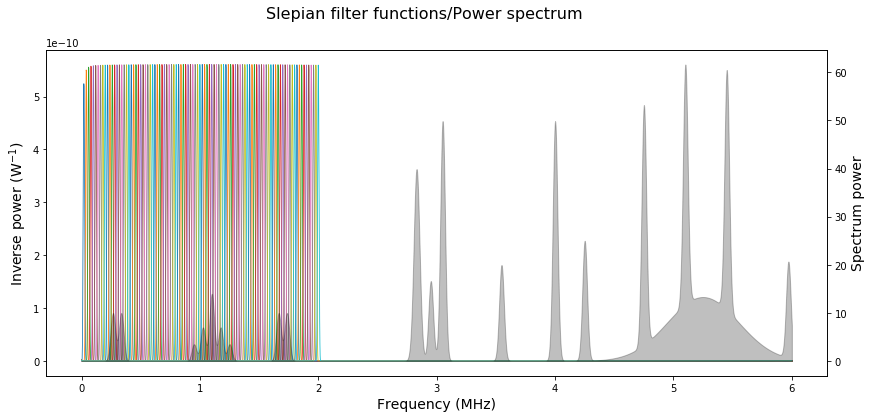

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(14, 6))
for ff in slepian_filter_functions:
    ax.plot(spectrum_frequencies / 1e6, ff, linewidth=0.8)

ax.set_xlabel("Frequency (MHz)", fontsize=14)
ax.set_ylabel("Inverse power (W$^{-1}$)", fontsize=14)
fig.suptitle("Slepian filter functions/Power spectrum", fontsize=16)

ax2 = ax.twinx()
ax2.fill_between(spectrum_frequencies / 1e6, spectrum / 1e3, 0, alpha=0.25, color="k")
ax2.set_ylabel("Spectrum power", fontsize=14)
plt.show()

As you can see, the Slepian-based pulses have a highly concentrated frequency response enabling you to interrogate an arbitrary section of the spectrum without out-of-band leakage. The reconstruction procedure you'll be using here can accommodate various sampling strategies - there are no strict requirements on the form of the sequences used as the reconstruction algorithm in BOULDER OPAL is much more flexible than the original SA technique. A good rule of thumb is to overlap the filter functions peaks half-way, as shown above. By paving the spectrum in this manner you are ensuring that all parts of the interrogation window are sufficiently sampled.

### Measurements

The measurements for Slepian-based controls in these notes are calculated using the filter function framework as described before, naturally in experimental applications, they would come from your device.

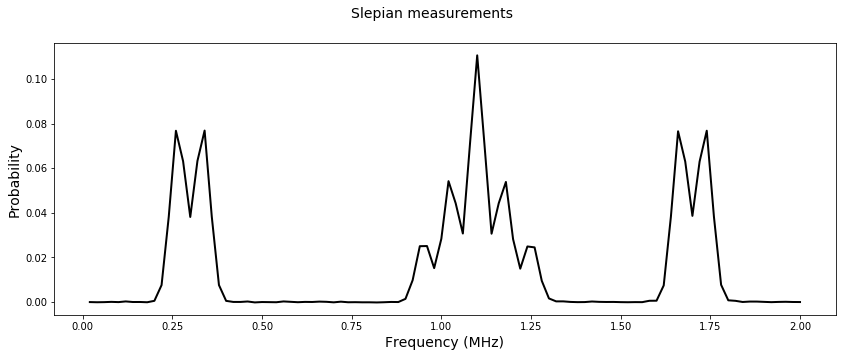

In [10]:
# Simulated measurements
shot_noise = 1e-4

slepian_measurements = []
for ff in slepian_filter_functions:
    measurement = np.trapz(ff * spectrum, x=spectrum_frequencies)
    # Shot noise
    measurement += np.random.default_rng().normal(0.0, shot_noise, 1)
    slepian_measurements.append(measurement)


# Plot
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(slepian_frequencies / 1e6, slepian_measurements, linewidth=2, color="k")
ax.set_xlabel("Frequency (MHz)", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=14)
fig.suptitle("Slepian measurements", fontsize=14)
plt.show()

The raw measurements obtained using the Slepian-based controls are free of artifacts and already reflect the spectrum closely.

### Mapping  between measurements and the power spectrum

To capture the full frequency response of your controls, the mapping $\mathbf{M}$ between the measurements $\mathbf{P}$ and the power spectrum $\mathbf{S}$ will be based on the filter function framework. The measurement associated with the $i^{th}$ control pulse can be expressed in discretized form as follows:
\begin{align*}
P_i = \sum_{j=1}^N F^i_j S_j \Delta \nu,
\end{align*}
where the filter function of the control $F^i$ and the spectrum $\mathbf{S}$ are sampled with spectral resolution $\Delta \nu = (\nu_{\rm max}-\nu_{\rm min})/N$. Therefore, scaling the filter functions of your controls by $\Delta \nu$ and arranging them in a matrix enables construction of $\mathbf{M}$, such that $\mathbf{P} = \mathbf{M}\mathbf{S}$.

This approach enables you to interrogate the spectrum window ($\nu_{\rm min}$,$\nu_{\rm max}$) in great detail by overlapping the filter functions to pave the spectrum as densely as needed. Note, here the method is paired with Slepian-based controls, however, it functions with any number of different controls even if they were mixed in the same reconstruction. Below is the construction of the mapping $\mathbf{M}$ using the filter functions computed in the earlier section.

In [11]:
# Filter functions over the sampled region stacked to from M
M = np.array([ff[sample_selection] for ff in slepian_filter_functions]) * (
    sample_frequencies[1] - sample_frequencies[0]
)

### Reconstruct the power spectrum with high accuracy

In the final step, you'll find an inverse of the mapping $M$ in order to reconstruct the interrogated section of the spectrum $\mathbf{S} = \mathbf{M^{-1}}\mathbf{P}$. BOULDER OPAL offers a couple of efficient inversion procedures powered by TensorFlow purpose built with spectral reconstruction in mind. They are based on single value decomposition (SVD) and convex optimization (CO). 

Both methods provide parameter free estimation needed for reconstruction of unknown power spectrum densities. The SVD procedure offers high numerical efficiency for smooth, slow-varying spectra, but may introduce unphysical oscillations in the reconstructed spectrum when these conditions are not met. By enforcing strict positivity, the CO inversion procedure provides superior results for spectra exhibiting abrupt changes and rapid variations, as in the current example. For this reason, you'll be using the CO procedure in the reconstruction implementation below. 

For more details and a comparison between the reconstruction methods, refer to [Ball et al.](https://arxiv.org/abs/2001.04060), as well as our noise spectrum reconstruction [User Guide](https://docs.q-ctrl.com/boulder-opal/user-guides/noise-characterization-and-reconstruction).

In [12]:
slepian_results = qc.inverse_problems_solvers.solve_inverse_problem(
    a_matrix=M, b_vector=np.array(slepian_measurements), bounds=(0.0, 1e9)
)
reconstructed_slepian_sampled_spectrum = slepian_results.value

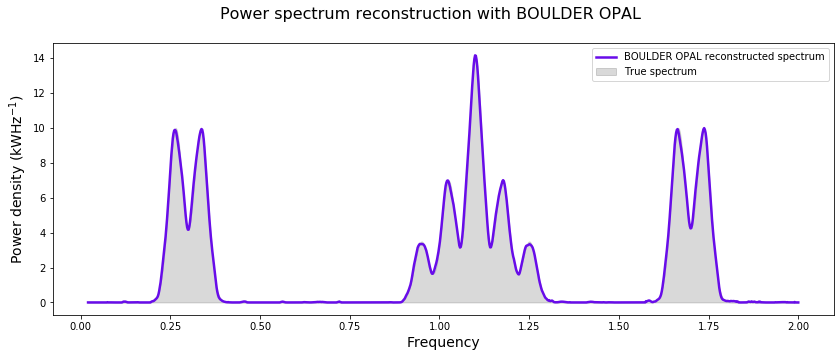

In [13]:
# plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(
    sample_frequencies / 1e6,
    sample_sepectrum / 1e3,
    0,
    alpha=0.15,
    color="k",
    label="True spectrum",
)
ax.plot(
    sample_frequencies / 1e6,
    reconstructed_slepian_sampled_spectrum / 1e3,
    "-",
    linewidth=2.5,
    color=colors["Q-CTRL"],
    label="BOULDER OPAL reconstructed spectrum",
)
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Power density (kWHz$^{-1}$)", fontsize=14)
ax.legend(loc="best")
fig.suptitle("Power spectrum reconstruction with BOULDER OPAL", fontsize=16)
plt.show()

By basing the reconstruction on detailed spectral response of your controls, BOULDER OPAL provides full flexibility in designing customized controls and sampling strategies to probe your spectra. The plot above shows a highly accurate power spectrum reconstruction using BOULDER OPAL tools for the case where concentrated, harmonics-free Slepian controls are used.